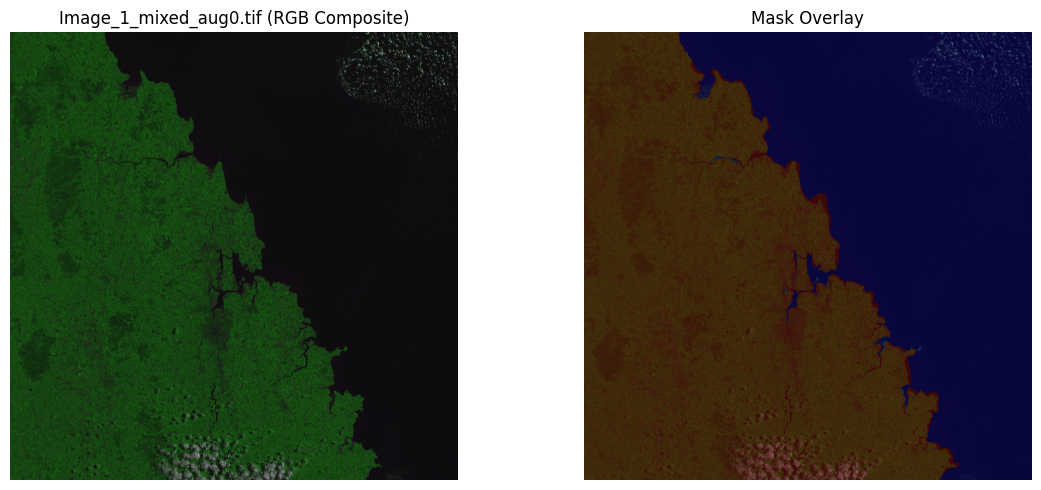

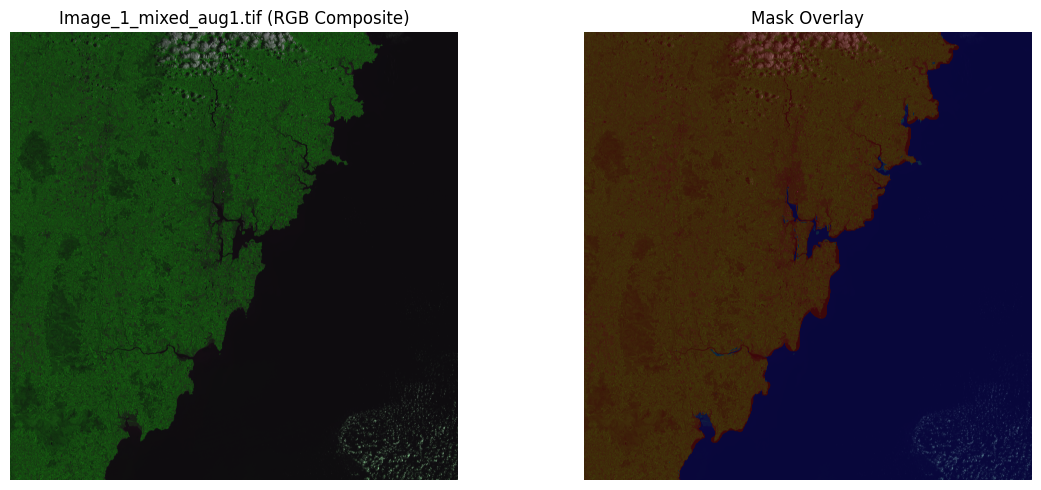

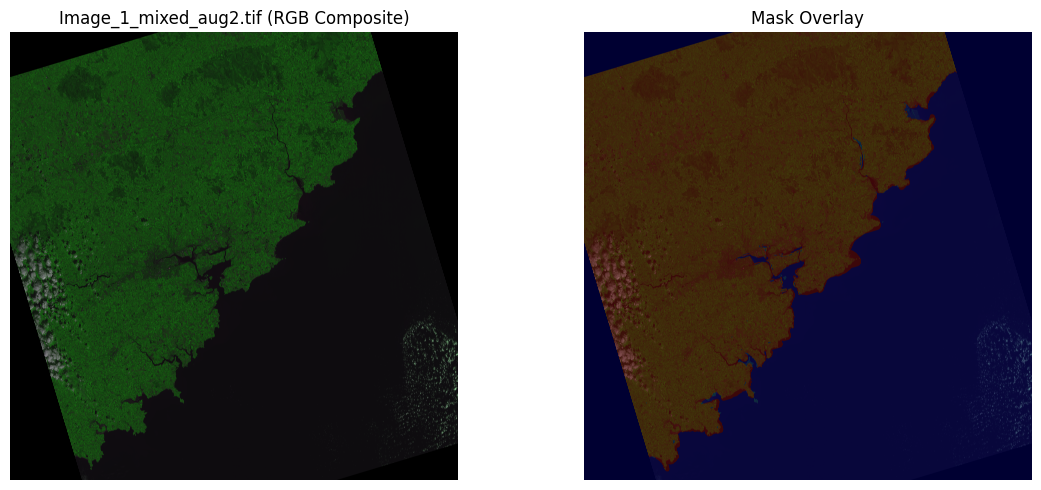

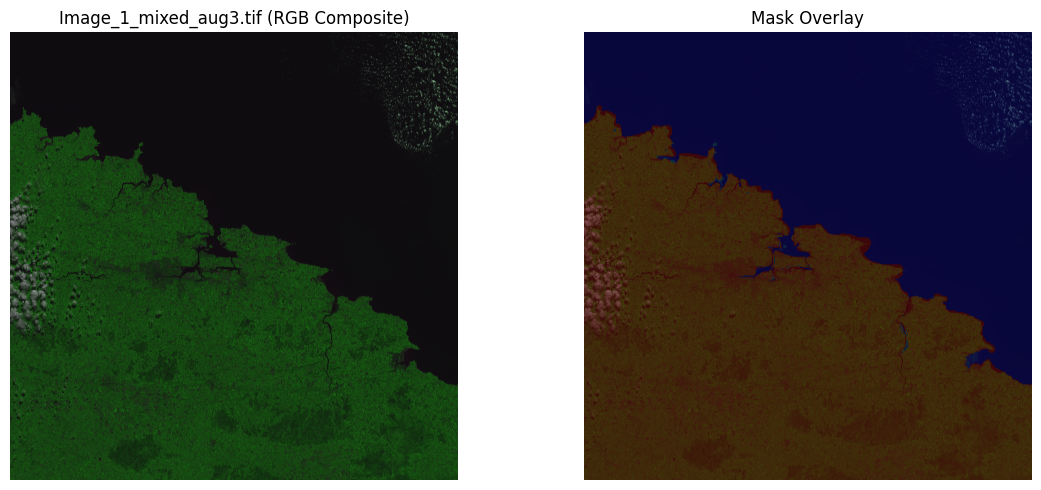

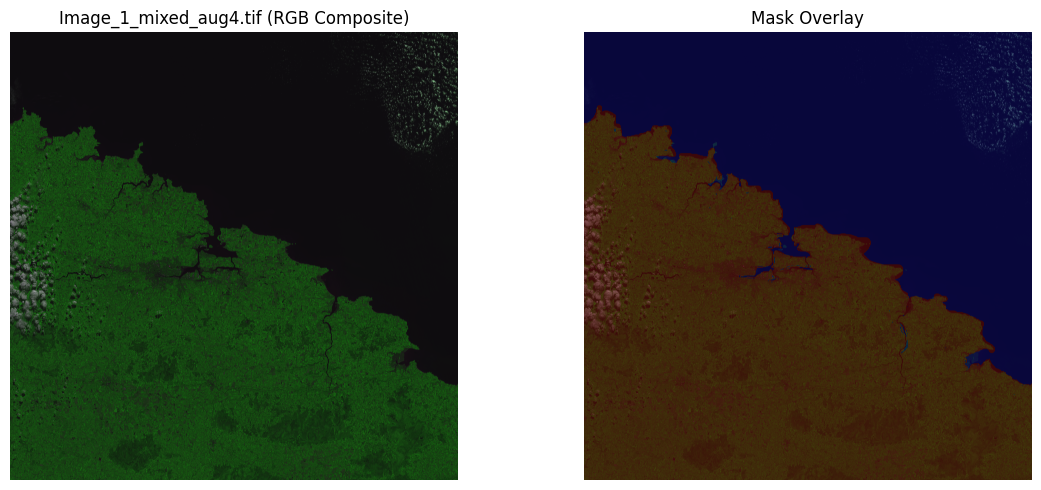

In [8]:
import os
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from PIL import Image

# Directories
imgDir = r"C:\Users\wasif\Desktop\AugTest\images"
maskDir = r"C:\Users\wasif\Desktop\AugTest\masks"

# Specific files to visualize
fileNames = [f"Image_1_mixed_aug{i}" for i in range(5)]

for baseName in fileNames:
    imgPath = os.path.join(imgDir, baseName + ".tif")
    maskPath = os.path.join(maskDir, baseName + ".png")

    # Load image (bands 4-3-2)
    with rasterio.open(imgPath) as src:
        img = src.read([4, 3, 2])
        img = np.moveaxis(img, 0, -1).astype(np.float32)
        img = (img - img.min()) / (img.max() - img.min() + 1e-6)

    # Load mask
    mask = np.array(Image.open(maskPath).convert("L")) / 255.0

    # Plot side-by-side
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title(f"{baseName}.tif (RGB Composite)")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(img)
    plt.imshow(mask, cmap="jet", alpha=0.4)
    plt.title("Mask Overlay")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


In [2]:
import os
import numpy as np
import rasterio
from PIL import Image
import albumentations as A

# ----------- Config ----------
stacked_img_path = r"C:\Users\wasif\Desktop\Annotated Images\stacked\Image_1_stacked.jp2"
mask_path = r"C:\Users\wasif\Desktop\Annotated Images\masks_resized\Image_1_annotated_resized.png"

output_img_dir = r"C:\Users\wasif\Desktop\AugTest\images"
output_mask_dir = r"C:\Users\wasif\Desktop\AugTest\masks"
os.makedirs(output_img_dir, exist_ok=True)
os.makedirs(output_mask_dir, exist_ok=True)

N_AUGS = 5
# ------------------------------

# Albumentations transform
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.3),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=30, border_mode=0, p=0.4)
])

# Load stacked image
with rasterio.open(stacked_img_path) as src:
    img_stack = src.read()  # (bands, H, W)
    meta = src.meta

img_stack_np = np.moveaxis(img_stack, 0, -1)  # (H, W, bands)
mask_np = np.array(Image.open(mask_path).convert("L"))

for i in range(N_AUGS):
    augmented = transform(image=img_stack_np, mask=mask_np)
    aug_img = np.moveaxis(augmented["image"], -1, 0)  # back to (bands, H, W)
    aug_mask = (augmented["mask"] > 127).astype(np.uint8) * 255

    # NDWI check
    B3 = aug_img[2]
    B8 = aug_img[7]
    ndwi = (B3 - B8) / (B3 + B8 + 1e-6)
    ndwi_ratio = np.sum(ndwi > 0.1) / ndwi.size
    land_ratio = np.sum(ndwi < -0.1) / ndwi.size

    if ndwi_ratio > 0.7:
        label = "water"
    elif land_ratio > 0.7:
        label = "land"
    else:
        label = "mixed"

    # Save image as JP2
    img_out_path = os.path.join(output_img_dir, f"Image_1_{label}_aug{i}.jp2")
    with rasterio.open(
        img_out_path, "w",
        driver="JP2OpenJPEG",
        height=aug_img.shape[1],
        width=aug_img.shape[2],
        count=aug_img.shape[0],
        dtype=aug_img.dtype,
        crs=meta["crs"],
        transform=meta["transform"]
    ) as dst:
        dst.write(aug_img)

    # Save mask
    mask_out_path = os.path.join(output_mask_dir, f"Image_1_{label}_aug{i}.png")
    Image.fromarray(aug_mask).save(mask_out_path)

    print(f"✅ Saved: {img_out_path} & {mask_out_path}")

print("\n🎉 Done augmenting one image + mask (saved as JP2 + PNG)!")


✅ Saved: C:\Users\wasif\Desktop\AugTest\images\Image_1_water_aug0.jp2 & C:\Users\wasif\Desktop\AugTest\masks\Image_1_water_aug0.png
✅ Saved: C:\Users\wasif\Desktop\AugTest\images\Image_1_water_aug1.jp2 & C:\Users\wasif\Desktop\AugTest\masks\Image_1_water_aug1.png
✅ Saved: C:\Users\wasif\Desktop\AugTest\images\Image_1_water_aug2.jp2 & C:\Users\wasif\Desktop\AugTest\masks\Image_1_water_aug2.png
✅ Saved: C:\Users\wasif\Desktop\AugTest\images\Image_1_water_aug3.jp2 & C:\Users\wasif\Desktop\AugTest\masks\Image_1_water_aug3.png
✅ Saved: C:\Users\wasif\Desktop\AugTest\images\Image_1_water_aug4.jp2 & C:\Users\wasif\Desktop\AugTest\masks\Image_1_water_aug4.png

🎉 Done augmenting one image + mask (saved as JP2 + PNG)!


In [4]:
import os
import numpy as np
import rasterio
from PIL import Image
import albumentations as A

# ----------- Config ----------
stackedImgPath = r"C:\Users\wasif\Desktop\Annotated Images\stacked\Image_1_stacked.jp2"
maskPath = r"C:\Users\wasif\Desktop\Annotated Images\masks_resized\Image_1_annotated_resized.png"

outputImgDir = r"C:\Users\wasif\Desktop\AugTest\images"
outputMaskDir = r"C:\Users\wasif\Desktop\AugTest\masks"
os.makedirs(outputImgDir, exist_ok=True)
os.makedirs(outputMaskDir, exist_ok=True)

nAugs = 5
# ------------------------------

# Albumentations transform
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.3),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=30, border_mode=0, p=0.4)
])

# Load stacked image
with rasterio.open(stackedImgPath) as src:
    imgStack = src.read()  # (bands, H, W)
    meta = src.meta

imgStackNp = np.moveaxis(imgStack, 0, -1)  # to (H, W, 12)

# Load binary mask
maskNp = np.array(Image.open(maskPath).convert("L"))

for i in range(nAugs):
    # Apply augmentation
    augmented = transform(image=imgStackNp, mask=maskNp)
    augImg = np.moveaxis(augmented["image"], -1, 0)  # (12, H, W)
    augMask = (augmented["mask"] > 127).astype(np.uint8) * 255

    # Classify by pixel values in mask
    totalPixels = augMask.size
    landPixels = np.sum(augMask == 255)
    waterPixels = np.sum(augMask == 0)

    if landPixels / totalPixels >= 0.9:
        label = "land"
    elif waterPixels / totalPixels >= 0.9:
        label = "water"
    else:
        label = "mixed"

    # Save image as .tif
    imgOutPath = os.path.join(outputImgDir, f"Image_1_{label}_aug{i}.tif")
    with rasterio.open(
        imgOutPath, "w",
        driver="GTiff",
        height=augImg.shape[1],
        width=augImg.shape[2],
        count=augImg.shape[0],
        dtype=augImg.dtype,
        crs=meta["crs"],
        transform=meta["transform"]
    ) as dst:
        dst.write(augImg)

    # Save mask
    maskOutPath = os.path.join(outputMaskDir, f"Image_1_{label}_aug{i}.png")
    try:
        Image.fromarray(augMask).save(maskOutPath)
        print(f"✅ Aug {i} → Saved as {label} | Image: {imgOutPath} | Mask: {maskOutPath}")
    except Exception as e:
        print(f"❌ Failed to save mask {maskOutPath}: {e}")

print("\n🎉 Done augmenting one image + mask!")


c:\Users\wasif\AppData\Local\Programs\Python\Python313\Lib\site-packages\albumentations\core\validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


✅ Aug 0 → Saved as mixed | Image: C:\Users\wasif\Desktop\AugTest\images\Image_1_mixed_aug0.tif | Mask: C:\Users\wasif\Desktop\AugTest\masks\Image_1_mixed_aug0.png
✅ Aug 1 → Saved as mixed | Image: C:\Users\wasif\Desktop\AugTest\images\Image_1_mixed_aug1.tif | Mask: C:\Users\wasif\Desktop\AugTest\masks\Image_1_mixed_aug1.png
✅ Aug 2 → Saved as mixed | Image: C:\Users\wasif\Desktop\AugTest\images\Image_1_mixed_aug2.tif | Mask: C:\Users\wasif\Desktop\AugTest\masks\Image_1_mixed_aug2.png
✅ Aug 3 → Saved as mixed | Image: C:\Users\wasif\Desktop\AugTest\images\Image_1_mixed_aug3.tif | Mask: C:\Users\wasif\Desktop\AugTest\masks\Image_1_mixed_aug3.png
✅ Aug 4 → Saved as mixed | Image: C:\Users\wasif\Desktop\AugTest\images\Image_1_mixed_aug4.tif | Mask: C:\Users\wasif\Desktop\AugTest\masks\Image_1_mixed_aug4.png

🎉 Done augmenting one image + mask!


In [ ]:
import os
import numpy as np
import rasterio
from PIL import Image
import albumentations as A

# ----------- Config ----------
stackedImgDir = r"C:\Users\wasif\Desktop\Annotated Images\stacked"
maskDir = r"C:\Users\wasif\Desktop\Annotated Images\masks_resized"

outputImgDir = r"C:\Users\wasif\Desktop\AugTest\images"
outputMaskDir = r"C:\Users\wasif\Desktop\AugTest\masks"
os.makedirs(outputImgDir, exist_ok=True)
os.makedirs(outputMaskDir, exist_ok=True)

nAugs = 5

# Albumentations transform
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.3),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=30, border_mode=0, p=0.4)
])

# Process all images
for file in os.listdir(stackedImgDir):
    if file.endswith("_stacked.jp2"):
        baseName = file.replace("_stacked.jp2", "")
        stackedImgPath = os.path.join(stackedImgDir, file)
        maskPath = os.path.join(maskDir, f"{baseName}_annotated_resized.png")

        if not os.path.exists(maskPath):
            print(f"❌ Mask not found for {baseName}, skipping.")
            continue

        with rasterio.open(stackedImgPath) as src:
            imgStack = src.read()
            meta = src.meta

        imgStackNp = np.moveaxis(imgStack, 0, -1)
        maskNp = np.array(Image.open(maskPath).convert("L"))

        for i in range(nAugs):
            augmented = transform(image=imgStackNp, mask=maskNp)
            augImg = np.moveaxis(augmented["image"], -1, 0)
            augMask = (augmented["mask"] > 127).astype(np.uint8) * 255

            totalPixels = augMask.size
            landPixels = np.sum(augMask == 255)
            waterPixels = np.sum(augMask == 0)

            if landPixels / totalPixels >= 0.9:
                label = "land"
            elif waterPixels / totalPixels >= 0.9:
                label = "water"
            else:
                label = "mixed"

            imgOutPath = os.path.join(outputImgDir, f"{baseName}_{label}_aug{i}.jp2")
            maskOutPath = os.path.join(outputMaskDir, f"{baseName}_{label}_aug{i}.png")

            try:
                with rasterio.open(
                    imgOutPath, "w",
                    driver="JP2OpenJPEG",
                    height=augImg.shape[1],
                    width=augImg.shape[2],
                    count=augImg.shape[0],
                    dtype=augImg.dtype,
                    crs=meta["crs"],
                    transform=meta["transform"]
                ) as dst:
                    dst.write(augImg)

                Image.fromarray(augMask).save(maskOutPath)

                print(f"✅ Aug {i} → Saved as {label} | Image: {imgOutPath} | Mask: {maskOutPath}")
            except Exception as e:
                print(f"❌ Failed to save for {baseName} aug {i}: {e}")

        print(f"🎯 Finished augmenting: {baseName}\n")

print("🎉 All images in folder processed and augmented!")


c:\Users\wasif\AppData\Local\Programs\Python\Python313\Lib\site-packages\albumentations\core\validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
c:\Users\wasif\AppData\Local\Programs\Python\Python313\Lib\site-packages\PIL\Image.py:3402: DecompressionBombWarning: Image size (120560400 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


✅ Aug 0 → Saved as mixed | Image: C:\Users\wasif\Desktop\AugTest\images\Image_20_mixed_aug0.jp2 | Mask: C:\Users\wasif\Desktop\AugTest\masks\Image_20_mixed_aug0.png
✅ Aug 1 → Saved as mixed | Image: C:\Users\wasif\Desktop\AugTest\images\Image_20_mixed_aug1.jp2 | Mask: C:\Users\wasif\Desktop\AugTest\masks\Image_20_mixed_aug1.png
✅ Aug 2 → Saved as mixed | Image: C:\Users\wasif\Desktop\AugTest\images\Image_20_mixed_aug2.jp2 | Mask: C:\Users\wasif\Desktop\AugTest\masks\Image_20_mixed_aug2.png
✅ Aug 3 → Saved as mixed | Image: C:\Users\wasif\Desktop\AugTest\images\Image_20_mixed_aug3.jp2 | Mask: C:\Users\wasif\Desktop\AugTest\masks\Image_20_mixed_aug3.png
✅ Aug 4 → Saved as mixed | Image: C:\Users\wasif\Desktop\AugTest\images\Image_20_mixed_aug4.jp2 | Mask: C:\Users\wasif\Desktop\AugTest\masks\Image_20_mixed_aug4.png
🎯 Finished augmenting: Image_20

✅ Aug 0 → Saved as water | Image: C:\Users\wasif\Desktop\AugTest\images\Image_21_water_aug0.jp2 | Mask: C:\Users\wasif\Desktop\AugTest\masks\I

In [2]:
import os

# Define directories
imageDir = r"C:\Users\wasif\Desktop\AugTest\stacked"
maskDir = r"C:\Users\wasif\Desktop\AugTest\masks_resized"

# Sort files to keep image-mask alignment
imageFiles = sorted([f for f in os.listdir(imageDir) if f.endswith(".jp2")])
maskFiles = sorted([f for f in os.listdir(maskDir) if f.endswith(".png")])

# Sanity check
assert len(imageFiles) == len(maskFiles), "Mismatch between number of images and masks!"

# Rename in sync
for idx, (imgFile, maskFile) in enumerate(zip(imageFiles, maskFiles), start=61):
    ext = os.path.splitext(imgFile)[1]
    
    newImgName = f"stacked_{idx}{ext}"
    newMaskName = f"mask_{idx}.png"
    
    os.rename(os.path.join(imageDir, imgFile), os.path.join(imageDir, newImgName))
    os.rename(os.path.join(maskDir, maskFile), os.path.join(maskDir, newMaskName))
    
    print(f"✅ Renamed: {imgFile} → {newImgName}, {maskFile} → {newMaskName}")

print("\n🎉 All image and mask files renamed successfully!")


✅ Renamed: Image_10_stacked.jp2 → stacked_61.jp2, image_10_annotated_resized.png → mask_61.png
✅ Renamed: Image_14_stacked.jp2 → stacked_62.jp2, image_14_annotated_resized.png → mask_62.png
✅ Renamed: Image_15_stacked.jp2 → stacked_63.jp2, image_15_annotated_resized.png → mask_63.png
✅ Renamed: Image_1_stacked.jp2 → stacked_64.jp2, image_1_annotated_resized.png → mask_64.png
✅ Renamed: Image_20_stacked.jp2 → stacked_65.jp2, image_20_annotated_resized.png → mask_65.png
✅ Renamed: Image_21_stacked.jp2 → stacked_66.jp2, image_21_annotated_resized.png → mask_66.png
✅ Renamed: Image_24_stacked.jp2 → stacked_67.jp2, image_24_annotated_resized.png → mask_67.png
✅ Renamed: Image_26_stacked.jp2 → stacked_68.jp2, image_26_annotated_resized.png → mask_68.png
✅ Renamed: Image_28_stacked.jp2 → stacked_69.jp2, image_28_annotated_resized.png → mask_69.png
✅ Renamed: Image_30_stacked.jp2 → stacked_70.jp2, image_2_annotated_resized.png → mask_70.png
✅ Renamed: Image_31_stacked.jp2 → stacked_71.jp2, ima

In [ ]:
- Annotate new images.
- Crop the images and balance the distribution.
- Train the Model
- Transfer the dataset on mac and use gpu to train prre trained model